In [1]:
### check image resize cifar 10
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:
!nvidia-smi

Wed Sep 18 00:41:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              3W /   78W |    5421MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip uninstall torch -y

Found existing installation: torch 2.4.1+cu124
Uninstalling torch-2.4.1+cu124:
  Successfully uninstalled torch-2.4.1+cu124


In [4]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.4.1%2Bcu124-cp310-cp310-linux_x86_64.whl (797.2 MB)


### Torch Tutorial Cifar-10

#### Import functions

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [6]:
torch.set_default_device('cpu') 

In [7]:
device = torch.device('cuda:0')

#### Prepared DataSet

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root="./../data/", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./../data/", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Prepare Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.hash1 = nn.Linear(120, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net = Net( HASH_SIZE )
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (hash1): Linear(in_features=120, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

#### Train Parameters

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
iterations = 15

In [11]:
for epoch in range( iterations ):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs, hash_ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print(i + 1, " ", end="")
            
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}] loss: {running_loss} accurancy: {100 * correct // total} %')

1  101  201  301  401  501  601  701  [1] loss: 1799.4546468257904 accurancy: 11 %
1  101  201  301  401  501  601  701  [2] loss: 1679.6961691379547 accurancy: 20 %
1  101  201  301  401  501  601  701  [3] loss: 1457.411836862564 accurancy: 31 %
1  101  201  301  401  501  601  701  [4] loss: 1329.5742181539536 accurancy: 38 %
1  101  201  301  401  501  601  701  [5] loss: 1233.182649731636 accurancy: 42 %
1  101  201  301  401  501  601  701  [6] loss: 1169.7982444763184 accurancy: 46 %
1  101  201  301  401  501  601  701  [7] loss: 1121.569790005684 accurancy: 48 %
1  101  201  301  401  501  601  701  [8] loss: 1076.4919879436493 accurancy: 50 %
1  101  201  301  401  501  601  701  [9] loss: 1038.1221888065338 accurancy: 52 %
1  101  201  301  401  501  601  701  [10] loss: 1000.88284522295 accurancy: 54 %
1  101  201  301  401  501  601  701  [11] loss: 967.7627692222595 accurancy: 56 %
1  101  201  301  401  501  601  701  [12] loss: 941.4992634654045 accurancy: 57 %
1  101  

#### Save Model

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### Load Model

In [13]:
net = Net( HASH_SIZE ).to(device)
net.load_state_dict(torch.load(PATH))

/tmp/ipykernel_20010/1647188953.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

#### Check visually

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

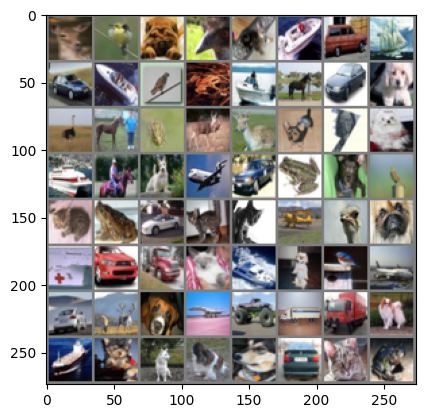

frog  bird  frog  bird  cat   plane car   ship  car   cat   bird  frog  ship  horse car   dog   deer  horse frog  deer  cat   dog   bird  ship  ship  horse dog   plane car   frog  dog   bird  frog  frog  car   dog   cat   plane bird  dog   ship  car   car   dog   plane cat   car   ship  ship  deer  frog  plane truck ship  truck dog   plane frog  cat   dog   ship  ship  dog   frog 
tensor([0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [15]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

outputs, hashes = net(images.to(device))
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[predicted[j]]:5s}' for j in range(predicted.shape[0])))
print(torch.round(hashes)[0])

#### Check Accurancy on test set

In [16]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


In [17]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.5 %
Accuracy for class: car   is 71.5 %
Accuracy for class: bird  is 38.8 %
Accuracy for class: cat   is 36.8 %
Accuracy for class: deer  is 52.9 %
Accuracy for class: dog   is 47.9 %
Accuracy for class: frog  is 79.1 %
Accuracy for class: horse is 64.2 %
Accuracy for class: ship  is 72.8 %
Accuracy for class: truck is 59.7 %


### CustomDataSet ( ImageNet )

In [18]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [19]:
IMAGENET_PATH = "../data/Imagenet32_train/"

In [20]:
import os
import _pickle as cPickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    dict_ = unpickle(data_file + str(idx))

    images = dict_['data']
    labels = dict_['labels']

    ## images_without_mean = dict_['mean']   ??? check is there are better results or not

    return images, labels

In [21]:
images2, labels2 = load_databatch(IMAGENET_PATH, 1)

In [22]:
print( type(images2) )
print( type(labels2) )

<class 'numpy.ndarray'>
<class 'list'>


In [23]:
images2 = images2.astype(np.float32).reshape(128116,3,32,32)

In [24]:
dataset = CustomDataset(torch.from_numpy(images2), torch.Tensor(labels2) )

In [25]:
ImageNetLoader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [26]:
correct = 0
total = 0

with torch.no_grad():
    for data in ImageNetLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 0 %


### Concat two models

In [27]:
class Net2(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.hash1 = nn.Linear(256, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = x.to(torch.float32)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net2 = Net2( HASH_SIZE )
net2.to(device)

Net2(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (hash1): Linear(in_features=256, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [28]:
from torchvision import models

resnet50 = models.resnet50(pretrained = True) # weights=ResNet50_Weights.DEFAULT
resnet50 = resnet50.to(device)
resnet50.fc = torch.nn.Identity()

for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True
    
for param in resnet50.layer4.parameters():
    param.requires_grad = True

#resnet50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
net2 = Net2( HASH_SIZE ).to(device)

In [30]:
model2 = nn.Sequential(resnet50, net2)

In [31]:
#model2

In [32]:
# https://discuss.pytorch.org/t/add-layers-on-pretrained-model/88760
# https://stackoverflow.com/questions/53901603/how-to-transfer-weight-of-own-model-to-same-network-but-different-number-of-clas
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492
# https://github.com/flyingpot/pytorch_deephash/blob/master/net.py

#https://www.kaggle.com/code/max237/resnet50-transfer-learning-in-pytorch
#https://datagen.tech/guides/computer-vision/resnet-50/#
#https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351
#https://blog.roboflow.com/how-to-use-resnet-50/
#https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/

In [33]:
criterion2 = nn.CrossEntropyLoss()
#optimizer2 = optim.AdamW(model2.parameters(), lr=0.000025, weight_decay=50)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
iterations = 50

In [34]:
for epoch in range( 10 ):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer2.zero_grad()

        #if epoch > 1:
        #    for param in model2[0].layer4.parameters():
        #        param.requires_grad = False

        outputs, hash_ = model2(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print(i + 1, " ", end="")
            
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}] loss: {running_loss} accurancy: {100 * correct // total} %')

1  101  201  301  401  501  601  701  [1] loss: 1197.5993085503578 accurancy: 46 %
1  101  201  301  401  501  601  701  [2] loss: 730.05732858181 accurancy: 67 %
1  101  201  301  401  501  601  701  [3] loss: 574.6806277036667 accurancy: 74 %
1  101  201  301  401  501  601  701  [4] loss: 467.28372409939766 accurancy: 79 %
1  101  201  301  401  501  601  701  [5] loss: 368.09161737561226 accurancy: 83 %
1  101  201  301  401  501  601  701  [6] loss: 296.2784384638071 accurancy: 86 %
1  101  201  301  401  501  601  701  [7] loss: 244.25041169673204 accurancy: 89 %
1  101  201  301  401  501  601  701  [8] loss: 198.40517219156027 accurancy: 91 %
1  101  201  301  401  501  601  701  [9] loss: 163.747683621943 accurancy: 92 %
1  101  201  301  401  501  601  701  [10] loss: 146.83995220065117 accurancy: 93 %


### Save model

In [35]:
PATH = './mainModel.pth'
#PATH = './modelResnetAndCifar.pth' # 45 jeden optimizer, pozniej 2-gi optimizer
#PATH = './modelResnetAndCifar5.pth' # jeden optimizer
torch.save(model2.state_dict(), PATH)

In [36]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 76.8 %
Accuracy for class: car   is 79.0 %
Accuracy for class: bird  is 59.4 %
Accuracy for class: cat   is 52.7 %
Accuracy for class: deer  is 61.8 %
Accuracy for class: dog   is 62.5 %
Accuracy for class: frog  is 76.6 %
Accuracy for class: horse is 70.7 %
Accuracy for class: ship  is 76.3 %
Accuracy for class: truck is 76.8 %


In [37]:
correct = 0
total = 0

total_labels = None
total_predictions = None

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


#### Another try 

In [38]:
resnet50_2 = models.resnet50(pretrained = True)
resnet50_2 = resnet50_2.to(device)

for param in resnet50_2.parameters():
    param.requires_grad = False

resnet50_2.fc = nn.Sequential(nn.Linear(2048, 256),
                         nn.ReLU(),
                         nn.Linear(256, 1),
                         nn.Sigmoid())

In [39]:
for param in resnet50_2.fc.parameters():
    param.requires_grad = True
    
# Unfreeze the last few layers of the model

for param in resnet50_2.layer4.parameters():
    param.requires_grad = True

In [40]:
# https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min
# https://www.kaggle.com/code/max237/resnet50-transfer-learning-in-pytorch

### mAP - evaluate

In [41]:
#https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/metrics/mean_avg_precision.py
#https://www.youtube.com/watch?v=FppOzcDvaDI
#https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html
#https://www.v7labs.com/blog/mean-average-precision
#https://yanfengliux.medium.com/the-confusing-metrics-of-ap-and-map-for-object-detection-3113ba0386ef
#https://github.com/flyingpot/pytorch_deephash/blob/master/evaluate.py

#https://medium.com/voice-tech-global/machine-learning-confidence-scores-all-you-need-to-know-as-a-conversation-designer-8babd39caae7

In [42]:
# https://www.youtube.com/watch?v=FppOzcDvaDI
# https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.binary_auprc.html
# https://pytorch.org/torcheval/main/generated/torcheval.metrics.functional.multiclass_auprc.html#torcheval.metrics.functional.multiclass_auprc

In [43]:
# praca magisterska
# 1. spor recall - precision
# 2. mAP co to jest 
# 3. PyTorch zapewnia metryki
# 4. dHash, pHash itp.
# 5. trzeci wlasny sens, przyklad w zyciu codziennym czy to ma sens ?

In [44]:
#!pip install torcheval

In [65]:
torch.cuda.empty_cache()
import gc
#del net
gc.collect()

3873

In [66]:
correct = 0
total = 0

testloader2 = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)

with torch.no_grad():
    for data in testloader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


In [67]:
print(outputs.shape)
print(labels.shape)
print(outputs[0])

torch.Size([10000, 10])
torch.Size([10000])
tensor([-6.0842, -0.5892, -2.2671, 10.8045,  0.3682,  4.2690,  2.1747, -1.6348,
        -3.1551, -4.4442], device='cuda:0')


In [68]:
from torcheval.metrics.functional import multiclass_auprc

In [69]:
print( "mAP value equals to: ", multiclass_auprc(outputs, labels))

mAP value equals to:  tensor(0.7425, device='cuda:0')


### CuNN

In [70]:
from typing import List, Dict, Tuple

class cuNN:
    def __init__(self, size, hash_size, images, size_images ):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = np.zeros([len(images), hash_size ]).astype(np.float32)
        self.hash_size = hash_size
        self.images = images;
        self.size_ = size_images

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        
        tensor_image = torch.FloatTensor(self.images).to("cuda:0")
        label, hash_ = model2(tensor_image)
        signatures = torch.round(hash_).cpu().detach().numpy().astype(np.int8)
        
        idx = 0
        for signature in signatures:
            self.signatures[idx] = np.packbits( signature ).astype(np.float32)
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures
    
    def compute_candidate(self):
        candidate_pairs = set()
        #list1 = []
        #list2 = []

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                               tuple([hash_bucket[i], hash_bucket[j]])
                            )
                            #list1.append(self.signatures[hash_bucket[i]]) 
                            #list2.append(self.signatures[hash_bucket[j]]) 
                            #list1.append(hash_bucket[i]) 
                            #list2.append(hash_bucket[j]) 
        return candidate_pairs
        #return list1, list2
    
    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [71]:
IMAGES = images2[0:1000]
print(IMAGES.shape)

(1000, 3, 32, 32)


In [72]:
nnLSH = cuNN(16, 8, IMAGES, 1000)
signatures = nnLSH.compute_hash()

pairs = nnLSH.compute_candidate()

print(len(pairs))
duplicates = nnLSH.check_candidate(pairs, 0.9)
print(duplicates[0])
print(len(duplicates))

333042
(95, 950, 0.984375)
800


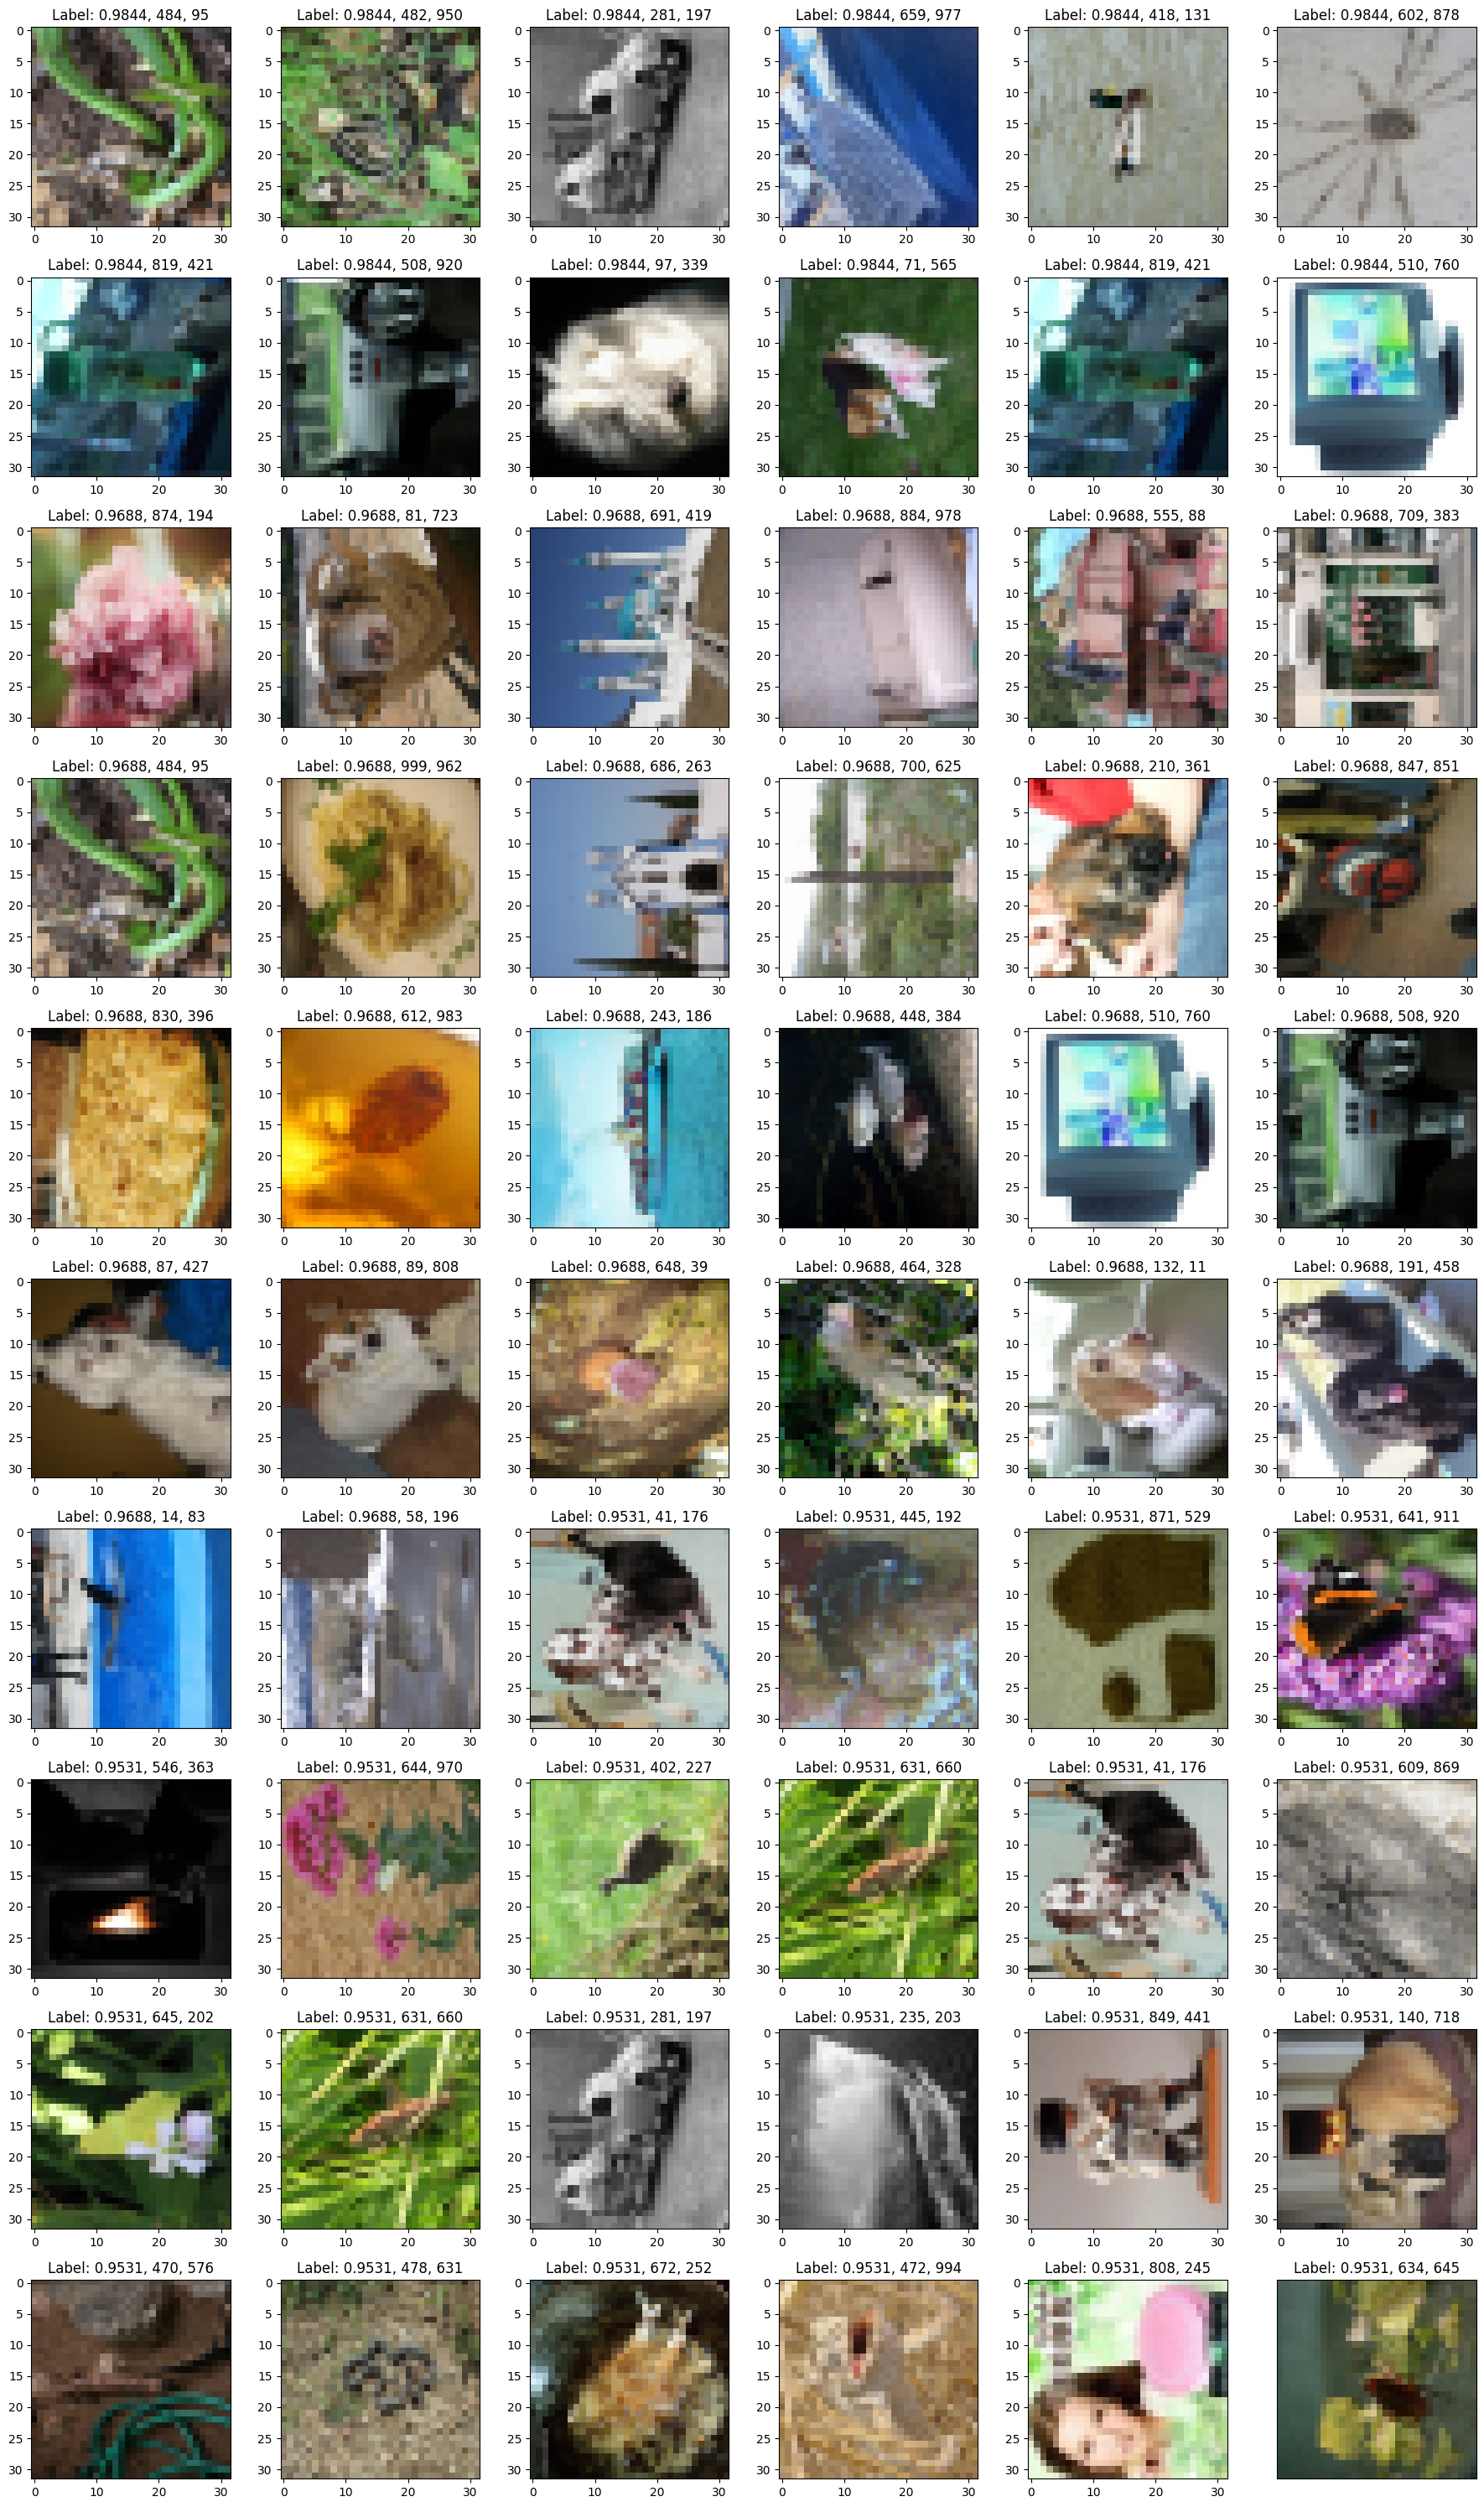

In [73]:
num_row = 10
num_col = 6

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(IMAGES[duplicates[i//2 + idx_start][0]].astype(np.uint8).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels2[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][0]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(IMAGES[duplicates[i//2 + idx_start][1]].astype(np.uint8).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels2[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][1]}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()